# Dataset Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# Data Loader

In [ ]:
class SymptomDiseaseDataset(Dataset):
    def __init__(self, csv_path, label_to_idx=None):
        data = pd.read_csv(csv_path)

        if "Unnamed: 0" in data.columns:
            data = data.drop(columns=["Unnamed: 0"])

        # Normalize label text
        data.iloc[:, -1] = (
            data.iloc[:, -1]
            .astype(str)
            .str.strip()
            .str.lower()
        )

        # Drop rows with missing labels
        data = data.dropna(subset=[data.columns[-1]])

        self.features = data.iloc[:, :-1]
        self.labels = data.iloc[:, -1]

        self.features = self.features.apply(pd.to_numeric, errors="coerce")
        self.features = self.features.fillna(0).astype(np.float32)

        self.symptom_names = list(self.features.columns)

        # Label mapping
        if label_to_idx is None:
            self.disease_names = sorted(self.labels.unique())
            self.label_to_idx = {d: i for i, d in enumerate(self.disease_names)}
        else:
            # Filter unseen labels in validation/test
            valid_mask = self.labels.isin(label_to_idx.keys())
            self.features = self.features[valid_mask]
            self.labels = self.labels[valid_mask]

            self.label_to_idx = label_to_idx
            self.disease_names = list(label_to_idx.keys())

        self.idx_to_label = {i: d for d, i in self.label_to_idx.items()}

        self.x = torch.tensor(self.features.values, dtype=torch.float32)
        self.y = torch.tensor(
            [self.label_to_idx[l] for l in self.labels],
            dtype=torch.long
        )

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# The "Gated Symptom Unit" (GSU)

In [ ]:
class GatedSymptomUnit(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.gate = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return x * torch.sigmoid(self.gate(x))


# Residual Reasoning Block

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, dim, dropout=0.2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.LayerNorm(dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.block(x)


# MEXAR Nano Main Model

In [ ]:
class MEXAR_Nano_V2(nn.Module):
    def __init__(self, input_dim=132, hidden_dim=64, num_classes=41):
        super().__init__()

        self.gsu = GatedSymptomUnit(input_dim)
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.res1 = ResBlock(hidden_dim)
        self.res2 = ResBlock(hidden_dim)

        self.bottleneck = nn.Linear(hidden_dim, 32)

        self.classifier = nn.Linear(32, num_classes)
        self.confidence_head = nn.Linear(32, 1)

    def forward(self, x):
        x = self.gsu(x)
        x = F.relu(self.input_proj(x))

        x = self.res1(x)
        x = self.res2(x)

        latent = F.relu(self.bottleneck(x))

        logits = self.classifier(latent)
        confidence = torch.sigmoid(self.confidence_head(latent))

        return logits, confidence, latent


# Explainability Engine (The "Reasoning" Output)

In [ ]:
class ExplainabilityEngine:
    def __init__(self, model, symptom_names, disease_names):
        self.model = model
        self.symptom_names = symptom_names
        self.disease_names = disease_names

    def diagnose_and_explain(self, input_vector):
        self.model.eval()

        for p in self.model.parameters():
            p.requires_grad = False

        x = input_vector.unsqueeze(0).clone().detach().to(device)
        x.requires_grad_(True)

        logits, confidence, _ = self.model(x)
        pred_idx = torch.argmax(logits, dim=1).item()
        disease = self.disease_names[pred_idx]

        score = logits[0, pred_idx]
        score.backward()

        grads = x.grad.abs().squeeze().cpu().numpy()
        input_np = x.detach().squeeze().cpu().numpy()

        active_idx = np.where(input_np > 0)[0]
        if len(active_idx) == 0:
            return disease, "No symptoms provided."

        contributions = [(self.symptom_names[i], grads[i]) for i in active_idx]
        contributions.sort(key=lambda x: x[1], reverse=True)

        top = contributions[:3]
        explanation = f"Diagnosed {disease} (Conf: {confidence.item():.2f}). Key factors: "
        explanation += ", ".join([f"{s} (impact {v:.3f})" for s, v in top])

        return disease, explanation

    def topk_diagnosis(self, input_vector, k=3):
        self.model.eval()

        x = input_vector.unsqueeze(0).to(device)

        with torch.no_grad():
            logits, confidence, _ = self.model(x)

        probs = torch.softmax(logits, dim=1).squeeze()
        topk_probs, topk_idx = probs.topk(k)

        results = []
        for prob, idx in zip(topk_probs, topk_idx):
            disease = self.disease_names[idx.item()]
            results.append((disease, prob.item()))

        return results



# Training Logic (Distillation Ready)

In [ ]:
def evaluate(model, dataloader):
    model.eval()
    correct, total, total_loss = 0, 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            logits, _, _ = model(x)
            loss = F.cross_entropy(logits, y)

            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()

    return total_loss / len(dataloader), correct / total


In [ ]:
def collect_predictions(model, dataloader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            logits, _, _ = model(x)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


In [ ]:
def confusion_matrix_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    return cm


In [ ]:
def per_class_accuracy(conf_matrix, class_names):
    results = []

    for i, name in enumerate(class_names):
        correct = conf_matrix[i, i]
        total = conf_matrix[i].sum()

        acc = correct / total if total > 0 else 0.0
        results.append((name, acc, correct, total))

    return results


In [ ]:
def topk_accuracy(logits, targets, k=3):
    _, topk = logits.topk(k, dim=1)
    correct = topk.eq(targets.unsqueeze(1))
    return correct.any(dim=1).float().mean().item()


In [ ]:
def evaluate_topk(model, dataloader, k=3):
    model.eval()
    total_topk = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            logits, _, _ = model(x)
            acc = topk_accuracy(logits, y, k)
            total_topk.append(acc)

    return np.mean(total_topk)


In [ ]:
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits, _, _ = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        val_loss, val_acc = evaluate(model, val_loader)

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc*100:.2f}%"
        )


In [ ]:
print("Train samples:", len(train_dataset))
print("Diseases:", len(train_dataset.disease_names))
print("Any NaN labels:", train_dataset.labels.isna().any())


Train samples: 4920
Diseases: 41
Any NaN labels: False


In [ ]:
if __name__ == "__main__":

    train_dataset = SymptomDiseaseDataset("/content/drive/MyDrive/training.csv")

    val_dataset = SymptomDiseaseDataset(
        "/content/drive/MyDrive/testing.csv",
        label_to_idx=train_dataset.label_to_idx
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model = MEXAR_Nano_V2(
        input_dim=132,
        num_classes=len(train_dataset.disease_names)
    ).to(device)

    train_model(model, train_loader, val_loader)

    explainer = ExplainabilityEngine(
        model,
        train_dataset.symptom_names,
        train_dataset.disease_names
    )

    sample_x, _ = val_dataset[0]
    disease, explanation = explainer.diagnose_and_explain(sample_x)

    print(disease)
    print(explanation)


Epoch 01 | Train Loss: 2.7432 | Val Loss: 1.0685 | Val Acc: 97.62%
Epoch 02 | Train Loss: 0.4502 | Val Loss: 0.1777 | Val Acc: 97.62%
Epoch 03 | Train Loss: 0.0736 | Val Loss: 0.1480 | Val Acc: 97.62%
Epoch 04 | Train Loss: 0.0330 | Val Loss: 0.1576 | Val Acc: 97.62%
Epoch 05 | Train Loss: 0.0180 | Val Loss: 0.1670 | Val Acc: 97.62%
Epoch 06 | Train Loss: 0.0121 | Val Loss: 0.1543 | Val Acc: 97.62%
Epoch 07 | Train Loss: 0.0090 | Val Loss: 0.1757 | Val Acc: 97.62%
Epoch 08 | Train Loss: 0.0068 | Val Loss: 0.1912 | Val Acc: 97.62%
Epoch 09 | Train Loss: 0.0058 | Val Loss: 0.1828 | Val Acc: 97.62%
Epoch 10 | Train Loss: 0.0041 | Val Loss: 0.1911 | Val Acc: 97.62%
Epoch 11 | Train Loss: 0.0039 | Val Loss: 0.1938 | Val Acc: 97.62%
Epoch 12 | Train Loss: 0.0032 | Val Loss: 0.1922 | Val Acc: 97.62%
Epoch 13 | Train Loss: 0.0029 | Val Loss: 0.1871 | Val Acc: 97.62%
Epoch 14 | Train Loss: 0.0029 | Val Loss: 0.2231 | Val Acc: 97.62%
Epoch 15 | Train Loss: 0.0024 | Val Loss: 0.2242 | Val Acc: 97

# ---- Confusion Matrix & Per-Class Accuracy ----

In [ ]:


y_true, y_pred = collect_predictions(model, val_loader)

cm = confusion_matrix_np(
    y_true,
    y_pred,
    num_classes=len(train_dataset.disease_names)
)

per_class_stats = per_class_accuracy(
    cm,
    train_dataset.disease_names
)

print("\nPer-Disease Accuracy:\n")

for name, acc, correct, total in per_class_stats:
    print(f"{name:30s} | Acc: {acc*100:6.2f}% | {correct}/{total}")



Per-Disease Accuracy:

acne                           | Acc: 100.00% | 1/1
aids                           | Acc: 100.00% | 1/1
alcoholic_hepatitis            | Acc: 100.00% | 1/1
allergy                        | Acc: 100.00% | 1/1
arthritis                      | Acc: 100.00% | 1/1
bronchial_asthma               | Acc: 100.00% | 1/1
cervical_spondylosis           | Acc: 100.00% | 1/1
chicken_pox                    | Acc: 100.00% | 1/1
chronic_cholestasis            | Acc: 100.00% | 1/1
common_cold                    | Acc: 100.00% | 1/1
dengue                         | Acc: 100.00% | 1/1
diabetes                       | Acc: 100.00% | 1/1
dimorphic_hemmorhoids(piles)   | Acc: 100.00% | 1/1
drug_reaction                  | Acc: 100.00% | 1/1
fungal_infection               | Acc:  50.00% | 1/2
gastroenteritis                | Acc: 100.00% | 1/1
gerd                           | Acc: 100.00% | 1/1
heart_attack                   | Acc: 100.00% | 1/1
hepatitis_a                    | Acc: 10

In [ ]:
print("\nMost Confused Diseases:\n")

confusions = []

for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 0:
            confusions.append((
                train_dataset.disease_names[i],
                train_dataset.disease_names[j],
                cm[i, j]
            ))

confusions.sort(key=lambda x: x[2], reverse=True)

for true_d, pred_d, count in confusions[:10]:
    print(f"{true_d} → {pred_d} : {count} cases")



Most Confused Diseases:

fungal_infection → chronic_cholestasis : 1 cases


In [ ]:
top3_acc = evaluate_topk(model, val_loader, k=3)
print(f"\nTop-3 Validation Accuracy: {top3_acc * 100:.2f}%")



Top-3 Validation Accuracy: 97.62%


In [ ]:
print("\nTop-3 Diagnoses:")
top3 = explainer.topk_diagnosis(sample_x)

for i, (disease, prob) in enumerate(top3, 1):
    print(f"{i}. {disease} (Probability: {prob:.3f})")



Top-3 Diagnoses:
1. fungal_infection (Probability: 1.000)
2. allergy (Probability: 0.000)
3. heart_attack (Probability: 0.000)


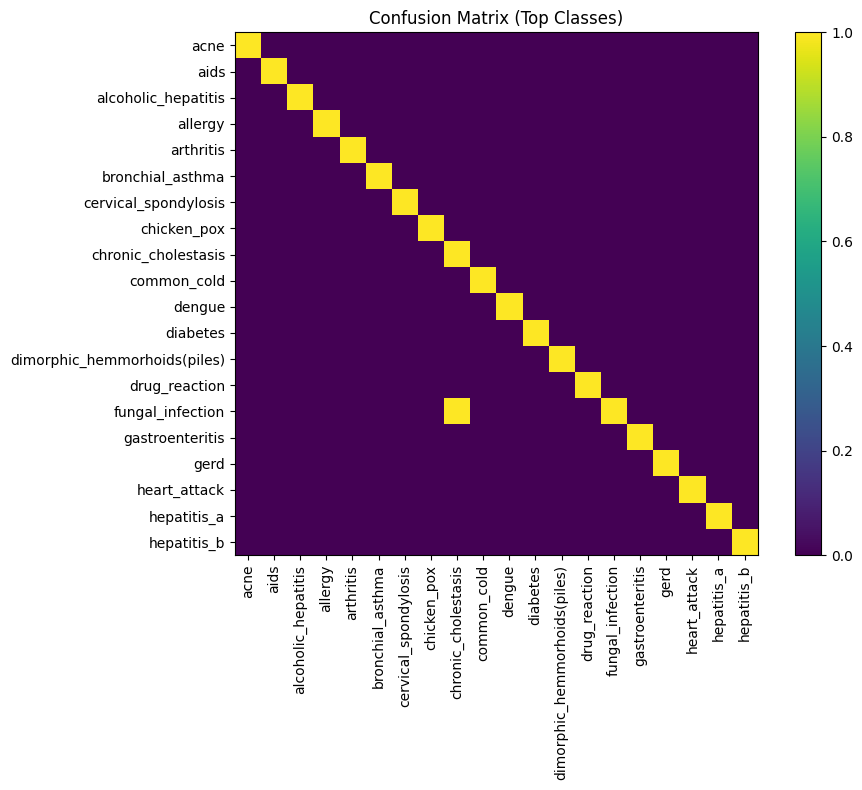

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names, max_classes=20):
    size = min(len(class_names), max_classes)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm[:size, :size])
    plt.xticks(range(size), class_names[:size], rotation=90)
    plt.yticks(range(size), class_names[:size])
    plt.colorbar()
    plt.title("Confusion Matrix (Top Classes)")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, train_dataset.disease_names)